In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/home3/sreich/MITgcm_c68w/MITgcm/utils/python/MITgcmutils')
from MITgcmutils import rdmds

sys.path.append('/home3/sreich/jupyter/jupyter_notebooks')
from read_write import *
from patchface3D import *

In [2]:
run_dir = '/nobackup/sreich/multigrid_test_ou/c68w/llc270/run.fwd_270.076c.simple.iter1/'

nz = 50
nx = 270
ny = 270*13

m_saltmon = rdmds(run_dir + 'm_saltmon.0000000001')
m_thetamon = rdmds(run_dir + 'm_thetamon.0000000001')

hfacc = rdmds(run_dir + 'hFacC')

m_thetamon.shape, m_saltmon.shape, hfacc.shape

((50, 3510, 270), (50, 3510, 270), (50, 3510, 270))

In [3]:
theta_data = read_float32(run_dir + 'T_monthly_woa09_highlatnearsurface_masked_llc270').reshape(12, nz, ny, nx)
salt_data = read_float32(run_dir + 'S_monthly_woa09_highlatnearsurface_masked_llc270').reshape(12, nz, ny, nx)


(568620000,)
(568620000,)


50
(270, 810, 50)


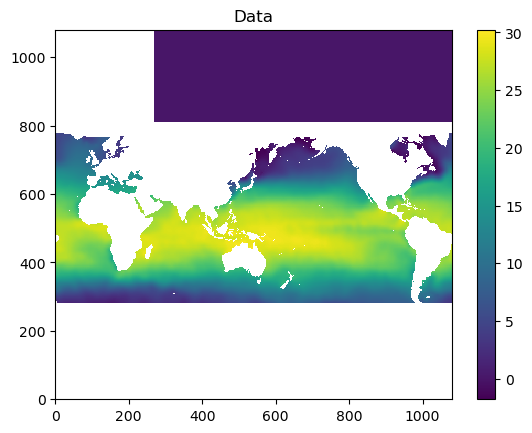

50
(270, 810, 50)


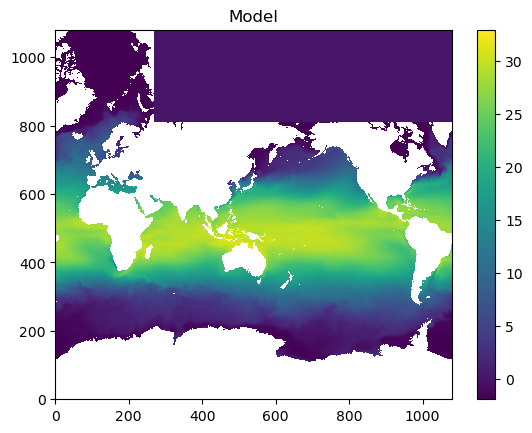

50
(270, 810, 50)


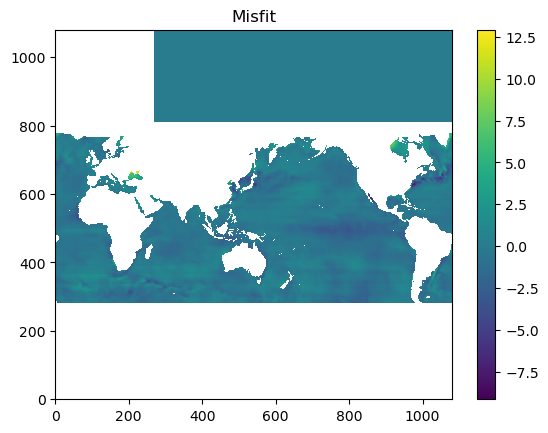

In [4]:
# Plot Data 

theta_data[theta_data <= -1.8] = np.nan
theta_data[theta_data >= 40] = np.nan

tmp = patchface3D(theta_data[0,:,:,:], nx, nz)

plt.pcolormesh(tmp[0,:,:])
plt.colorbar()
plt.title('Data')
plt.show()


# Plot model equivalent

m_thetamon[m_thetamon ==0 ] = np.nan

plt.pcolormesh(patchface3D(m_thetamon, nx, nz)[0,:,:])
plt.colorbar()
plt.title('Model')
plt.show()


plt.pcolormesh(tmp[0,:,:] - patchface3D(m_thetamon, nx, nz)[0,:,:])
plt.colorbar()
plt.title('Misfit')
plt.show()


# Confirm High-Res Cost

In [4]:
theta_data[theta_data <= -1.8] = np.nan
theta_data[theta_data >= 40] = np.nan


misfit_theta = m_thetamon - theta_data[0,:,:,:]

err_theta = read_float32(run_dir + 'Theta_sigma_smoothed_method_02_masked_merged_capped_llc270_areascaled.bin').reshape(nz, ny, nx)

err_theta[err_theta == 0] = np.nan
cost_theta = (misfit_theta / err_theta)**2

np.nansum(cost_theta), np.count_nonzero(~np.isnan(cost_theta))



(47385000,)


(13568188.97550818, 19651746)

In [5]:
salt_data[salt_data <= 25] = np.nan
salt_data[salt_data >= 40] = np.nan

misfit_salt = (m_saltmon - salt_data[0,:,:,:])

err_salt = read_float32(run_dir + 'Salt_sigma_smoothed_method_02_masked_merged_capped_llc270_areascaled.bin').reshape(nz, ny, nx)

err_salt[err_salt == 0] = np.nan
cost_salt = (misfit_salt / err_salt)**2

np.nansum(cost_salt), np.count_nonzero(~np.isnan(cost_salt))


(47385000,)


(24269473.797876526, 19701868)

In [6]:
xx_atemp = read_float32(run_dir + 'xx_atemp.0000000001.data').reshape(4, ny, nx)
xx_theta = read_float32(run_dir + 'xx_theta.0000000001.data').reshape(nz, ny, nx)
xx_salt = read_float32(run_dir + 'xx_salt.0000000001.data').reshape(nz, ny, nx)


# close enough
np.nansum(xx_atemp**2), np.nansum(xx_theta**2), np.nansum(xx_salt**2)

(3790800,)
(47385000,)
(47385000,)


(0.13087659, 214.222, 435.0883)

# Coarsen Cost

In [7]:
nxlr = 90
nylr = nxlr*13

reshaped_cost_salt = cost_salt.reshape(nz, nylr, 3, nxlr, 3)

lr_cost_salt = reshaped_cost_salt.mean(axis=(2, 4))


np.nansum(lr_cost_salt), np.count_nonzero(~np.isnan(lr_cost_salt))

(1462153.3080275042, 1024687)

In [8]:
reshaped_cost_theta = cost_theta.reshape(nz, nylr, 3, nxlr, 3)

lr_cost_theta = reshaped_cost_theta.mean(axis=(2, 4))


np.nansum(lr_cost_theta), np.count_nonzero(~np.isnan(lr_cost_theta))

(630957.3973027641, 1019492)

In [9]:
ctrl_atemp = xx_atemp**2

reshaped_cost_xx_atemp = ctrl_atemp.reshape(4, nylr, 3, nxlr, 3)

lr_xx_atemp = reshaped_cost_xx_atemp.mean(axis=(2, 4))

np.nansum(lr_xx_atemp)

0.014541836

In [10]:
ctrl_theta = xx_theta**2

reshaped_cost_xx_theta = ctrl_theta.reshape(nz, nylr, 3, nxlr, 3)

lr_xx_theta = reshaped_cost_xx_theta.mean(axis=(2, 4))

np.nansum(lr_xx_theta)

23.802519

In [11]:
ctrl_salt = xx_salt**2

reshaped_cost_xx_salt = ctrl_salt.reshape(nz, nylr, 3, nxlr, 3)

lr_xx_salt = reshaped_cost_xx_salt.mean(axis=(2, 4))

np.nansum(lr_xx_salt)

48.34316

In [12]:
1365824.8047692461 + 634581.5992330161 + 0.014541836 + 23.802519 + 48.34316

2000478.564223098